# Comparison MLPC, XGboost, NN


2023-11-06

In [1]:
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sklearn.set_config(transform_output="pandas")

2023-11-21 14:18:16.730007: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 14:18:16.766985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 14:18:16.767009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 14:18:16.767029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 14:18:16.773904: I tensorflow/core/platform/cpu_feature_g

In [2]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


def select_samples(name, n=None, sample_names_to_check=None):
    index_list = []
    for index, sample_description in enumerate(sample_names_to_check):
        if name in sample_description and len(name) == len(sample_description):
            index_list.append(index)

    return index_list[:n]


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
        return X

In [7]:
included_sample_names = [
    "CL-307",
    "CRX-527",
    "Fla-PA",
    "IMDM",
    "LPS",
    "LTA",
    "PGN",
    "Pam3",
    "R848",
]

In [37]:
file_name = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_7128_old_64_train.csv"
data = pd.read_csv(file_name)

labels = data["sample"]
features = data.drop(columns=["sample"])

In [38]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=4)
outliers = clf.fit_predict(features)
mask = [outlier != -1 for outlier in outliers]
features = features[mask]
labels = labels[mask]

features_train = features.reset_index(drop=True)
labels_train = labels.reset_index(drop=True)

X_train = features_train
y_train = labels_train

In [39]:
file_name = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_105_test_set.csv"
data = pd.read_csv(file_name)

labels = data["sample"]
features = data.drop(columns=["sample"])
index_list = []
for name in included_sample_names:
    index_list.extend(select_samples(name, n=500, sample_names_to_check=labels))

features_test = features.iloc[index_list]
labels_test = labels.iloc[index_list]
X_test = features_test
y_test = labels_test

In [40]:
import time
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
)
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)


feature_transformer = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("drop_constant_feature", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("cap_outliers", Winsorizer(capping_method="gaussian", tail="right", fold=3)),
    ]
)

feature_selector = Pipeline(
    [
        ("select_k_best", SelectKBest(chi2, k=1000)),
        (
            "trasnform_and_scale",
            PowerTransformer(method="yeo-johnson", standardize=True),
        ),
        ("select_forest", SelectFromModel(forest, max_features=300, threshold=0.001)),
    ]
)

print("Number of features before: ", X_train.shape[1])
start_time = time.time()


X_train = feature_transformer.fit_transform(X_train)
X_test = feature_transformer.transform(X_test)

feature_selector.fit(X_train, y_train)
X_train = feature_selector.transform(X_train)
X_test = feature_selector.transform(X_test)

end_time = time.time()
print("Number of features after: ", X_train.shape[1])
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Number of features before:  19992
Number of features after:  322
Elapsed time: 33.39 seconds


<Axes: title={'center': 'Count (target)'}, xlabel='sample'>

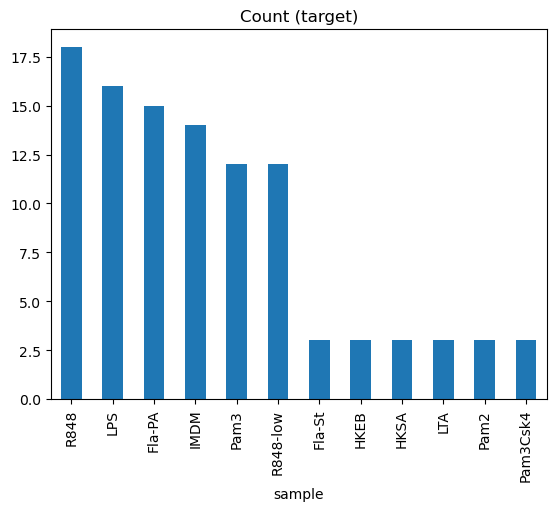

In [41]:
data["sample"].value_counts().plot(kind="bar", title="Count (target)")

In [42]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)
data, labels = sm.fit_resample(features, labels)

<Axes: title={'center': 'Count (target)'}, xlabel='sample'>

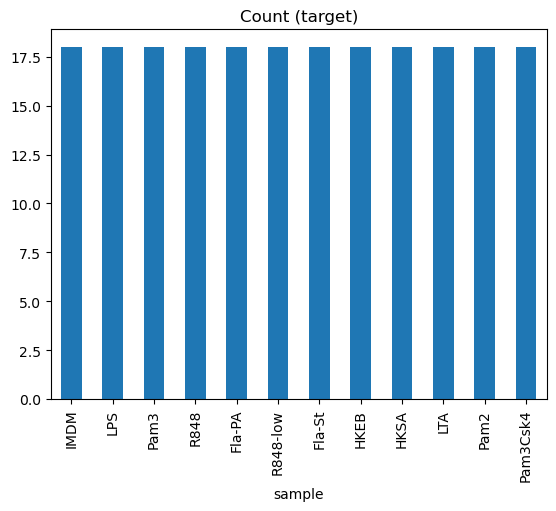

In [43]:
labels.value_counts().plot(kind="bar", title="Count (target)")

In [44]:
X_train.shape

(64, 322)

In [45]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [46]:
X_train.shape

(135, 322)

In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [48]:
y_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [49]:
from tensorflow.keras.utils import to_categorical

y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)
num_classes = y_train_nn.shape[1]
num_classes

9

In [50]:
# Defines the best parameters for NN
config = {
    "l1": 1200,
    "l2": 900,
    "l3": 450,
    "l4": 270,
    "batch_size": 8,
    "activation": "elu",
    "epochs": 200,
    "learning_rate": 0.001,
    "loss": "categorical_crossentropy",
    "dropout_rate1": 0.5,
    "dropout_rate2": 0.7,
    "dropout_rate3": 0.8,
    "dropout_rate4": 0.8,
}

In [51]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, verbose=0, mode="min", restore_best_weights=True
)

In [52]:
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.constraints import MaxNorm


def nn():
    with tf.device("/GPU:0"):
        batch_size = config.get("batch_size")
        activation = config.get("activation")
        epochs = config.get("epochs")
        learning_rate = config.get("learning_rate")
        loss = config.get("loss")
        l1 = config.get("l1")
        l2 = config.get("l2")
        l3 = config.get("l3")
        l4 = config.get("l4")

        dropout_rate1 = config.get("dropout_rate1")
        dropout_rate2 = config.get("dropout_rate2")
        dropout_rate3 = config.get("dropout_rate3")
        dropout_rate4 = config.get("dropout_rate4")
        batch_size = config.get("batch_size")
        epochs = config.get("epochs")

        inputs = keras.Input(shape=X_train.shape[1])
        x = keras.layers.UnitNormalization()(inputs)

        x = keras.layers.Dense(
            l1,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate1)(x)

        x = keras.layers.Dense(
            l2,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate2)(x)

        x = keras.layers.Dense(
            l3,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate3)(x)

        x = keras.layers.Dense(
            l4,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate4)(x)

        outputs = keras.layers.Dense(9, activation="softmax")(x)

        model = keras.Model(
            inputs=inputs,
            outputs=outputs,
            name="MATseq_NN_multiclass_classifier_v0.3",
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=loss,
            metrics=[
                "accuracy",
                keras.metrics.AUC(name="auc"),
            ],
        )

        model.fit(
            X_train,
            y_train_nn,
            epochs=epochs,
            batch_size=batch_size,
            verbose=True,
            callbacks=[earlystopper],
        )

        return model

In [53]:
# nn_model = nn()

In [54]:
# nn_model.save("/home/t.afanasyeva/MATseq/notebooks/MATseq_NN_multiclass_classifier_v0.3.keras", overwrite=True)

In [55]:
nn_model = keras.models.load_model(
    "/home/t.afanasyeva/MATseq/notebooks/MATseq_NN_multiclass_classifier_v0.3.keras"
)

In [56]:
nn_model.summary()

Model: "MATseq_NN_multiclass_classifier_v0.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 322)]             0         
                                                                 
 unit_normalization_1 (Unit  (None, 322)               0         
 Normalization)                                                  
                                                                 
 dense_5 (Dense)             (None, 1200)              387600    
                                                                 
 dropout_4 (Dropout)         (None, 1200)              0         
                                                                 
 dense_6 (Dense)             (None, 900)               1080900   
                                                                 
 dropout_5 (Dropout)         (None, 900)               0         
                              

In [57]:
# Defines the best parameters for NN
config = {
    "l1": 1200,
    "l2": 900,
    "l3": 450,
    "l4": 270,
    "batch_size": 8,
    "activation": "elu",
    "epochs": 400,
    "learning_rate": 0.001,
    "loss": "categorical_crossentropy",
    "dropout_rate1": 0.5,
    "dropout_rate2": 0.7,
    "dropout_rate3": 0.8,
    "dropout_rate4": 0.8,
}

In [58]:
# Defines the best parameters for MLPC
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

In [59]:
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

mlpc = MLPClassifier(**params)
bst = XGBClassifier(n_estimators=75, max_depth=20, learning_rate=0.001)

In [60]:
models = {
    "MLPClassifier": mlpc,
    "XGBClassifier": bst,
    "NeuralNetwork": nn_model,
}

In [61]:
from sklearn.metrics import accuracy_score, f1_score

In [62]:
model_names = []
accuracy_scores = []
f1_scores = []
predictions = []

for name, model in models.items():
    if name == "NeuralNetwork":
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_pred = train_pred.argmax(axis=1)
        test_pred = test_pred.argmax(axis=1)

    else:
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

    # Evaluate model performance
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average="macro")
    test_f1 = f1_score(y_test, test_pred, average="macro")

    # Print model performance
    print("*" * 50)
    print(f"{name} Training score:")
    print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
    print("-" * 20)
    print(f"{name} Validation score:")
    print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

    # Append model name and metrics to lists
    model_names.append(name)
    accuracy_scores.append(test_accuracy)
    f1_scores.append(test_f1)

**************************************************
MLPClassifier Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
MLPClassifier Validation score:
Accuracy: 0.5256 | F1 score: 0.3426


/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

**************************************************
XGBClassifier Training score:
Accuracy: 0.9926 | F1 score: 0.9926
--------------------
XGBClassifier Validation score:
Accuracy: 0.2949 | F1 score: 0.1612
3/3 [==============================] - 0s 2ms/step
**************************************************
NeuralNetwork Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
NeuralNetwork Validation score:
Accuracy: 0.5769 | F1 score: 0.4464


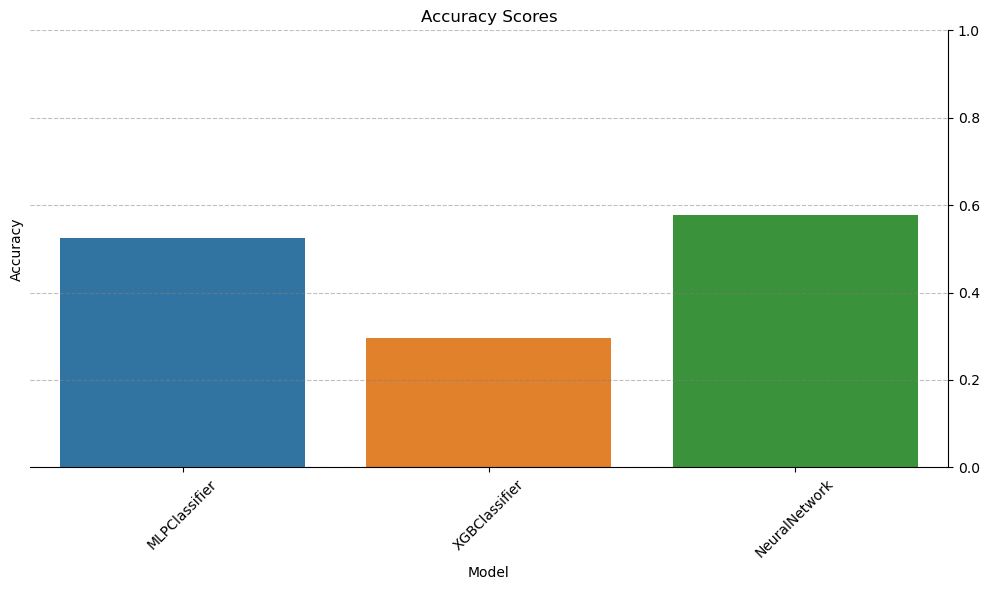

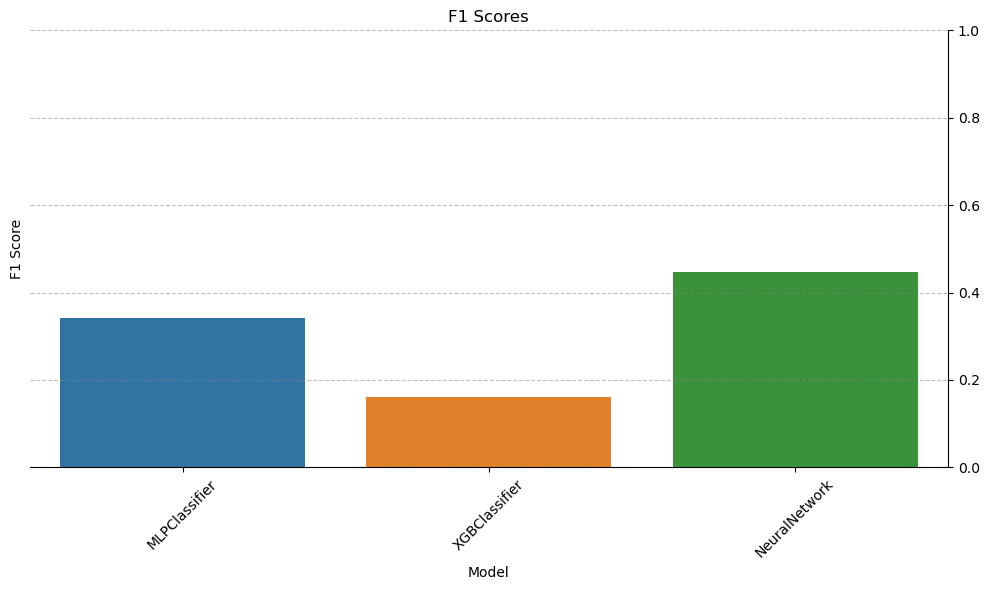

In [67]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, hue=model_names, legend=False)
plt.title("Accuracy Scores")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, hue=model_names, legend=False)
plt.title("F1 Scores")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)


plt.tight_layout()
plt.show()